In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import resample
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 25}
plt.rcParams.update(parameters)

DATAPATH = f'../dr-you-ecg-20220420_mount/DachungBoo_TMT/dhkim2'
desired_stages = ['SITTING',
                  'STAGE 1',
                  'STAGE 2',
                  'STAGE 3',
                  'STAGE 4',
                  'resting',
                ]
SAVE_PATH = f'./dataset/angio/train'


In [2]:
database = pd.read_csv(f'use_this_data/20230805_CAD_DF_FINAL.csv')
fnames = [name.split('/')[-1] for name in database['fname'].to_list()]
labels = [label for label in database['CAD'].to_list()]
database

,patientID,AcqDate,fname,headCTDate,CAD_CT,total.calcium.score,AngioDate,CAD_ANGIO,CAD
0,270948,06-18-2021,Case4/2062448#AHN#2021_06_18#09_12_28,2021-07-02,0,0.0,NaN,0,0
1,406838,01-12-2023,Case4/1760003#JANG#2023_01_12#15_38_08,2023-01-12,0,41.0,NaN,0,0
2,456189,12-15-2020,Case4/2497358#Kang#2020_12_15#13_35_09,2020-09-29,0,0.0,NaN,0,0
3,456189,09-29-2020,Case4/2497358#Kang#2020_09_29#13_37_55,2020-09-29,0,0.0,NaN,0,0
4,461683,12-06-2021,Case4/2338063#Kim#2021_12_06#14_22_43,2021-12-06,0,0.5,NaN,0,0
...,...,...,...,...,...,...,...,...,...
1627,10534581,12-31-2021,Case2/10487563#Lee#2021_12_31#09_06_52,NaN,0,NaN,2022-01-25,1,1
1628,10807958,08-17-2022,Case2/10639018#Choi#2022_08_17#14_22_54,NaN,0,NaN,2022-08-24,1,1
1629,10832854,09-21-2022,Case3/10654673#Chung#2022_09_21#14_10_50,NaN,0,NaN,2022-09-29,1,1
1630,10879679,09-14-2022,Case5/10682095#Kim#2022_09_14#15_22_59,NaN,0,NaN,2022-09-28,1,1


In [3]:
def calc_ratio(y):
    a = y.count(0)
    b = y.count(1)
    return b/(a+b)

def resample_data(data, original_rate=500, target_rate=250):
    original_length = data.shape[0]
    target_length = int(original_length * target_rate / original_rate)
    resampled_data = resample(data, target_length)
    return resampled_data

def filter_data(data, shape=(1, 12, 2500)):
    if len(data) != 0:
        return data[len(data)//2].reshape(shape)
    else:
        return np.zeros(shape)
    
def process_file(file):
    f, label   = file[0], file[1]
    stage_file = f'{DATAPATH}/{f}_s_list.csv'
    user_data  = {stage: [] for stage in desired_stages}
    if os.path.exists(stage_file):
        df = pd.read_csv(stage_file)
        for idx in range(len(df)):
            stage = str(df.loc[idx]['StageName'])
            stripIndex = df.loc[idx]['StripIndex']
            
            for stage_ in desired_stages[:-1]:
                if stage_ in stage:
                    data = pd.read_csv(f'{DATAPATH}/{f}_s_i{stripIndex}.csv')
                    data = resample_data(data.to_numpy()).transpose(1,0)
                    user_data[stage_].append(data)
            
            if '#' in stage:
                data = pd.read_csv(f'{DATAPATH}/{f}_s_i{stripIndex}.csv')
                data = resample_data(data.to_numpy()).transpose(1,0)
                user_data['resting'].append(data)
        datas = np.vstack([filter_data(user_data[data]) for data in desired_stages])
        np.savez_compressed(f'{SAVE_PATH}/{f}.npz',\
                        id    = f,\
                        data  = datas,\
                        label = int(label))
    else:
        print(f"*** {f} DOESN'T HAVE STAGE INFORMATION! ***", flush=True)
    

In [4]:
angio_files  = database[database['AngioDate'].fillna(0)!=0]['fname'].to_list()
angio_labels = database[database['AngioDate'].fillna(0)!=0]['CAD'].to_list()
angio_files  = [file.split('/')[-1] for file in angio_files]
angio_train_files, angio_test_files, angio_train_y, angio_test_y = train_test_split(angio_files, angio_labels, test_size=0.2, random_state=42)

In [5]:
# SAVE_PATH = f'./dataset/angio/train'
# os.makedirs(SAVE_PATH, exist_ok=True)
# target = np.vstack([angio_train_files, angio_train_y]).transpose(1,0)
# with ThreadPoolExecutor(max_workers=16) as executor:
#     results = list(tqdm(executor.map(process_file, target), total=len(target)))

In [6]:
# SAVE_PATH = f'./dataset/angio/test'
# os.makedirs(SAVE_PATH, exist_ok=True)
# target = np.vstack([angio_test_files, angio_test_y]).transpose(1,0)
# with ThreadPoolExecutor(max_workers=16) as executor:
#     results = list(tqdm(executor.map(process_file, target), total=len(target)))

In [7]:
non_angio_files  = database[database['AngioDate'].fillna(0)==0]['fname'].to_list()
non_angio_labels = database[database['AngioDate'].fillna(0)==0]['CAD'].to_list()
non_angio_files  = [file.split('/')[-1] for file in non_angio_files]
non_angio_train_files, non_angio_test_files, non_angio_train_y, non_angio_test_y = train_test_split(non_angio_files, non_angio_labels, test_size=0.2, random_state=42)

In [8]:
# SAVE_PATH = f'./dataset/non_angio/train'
# os.makedirs(SAVE_PATH, exist_ok=True)
# target = np.vstack([non_angio_train_files, non_angio_train_y]).transpose(1,0)
# with ThreadPoolExecutor(max_workers=16) as executor:
#     results = list(tqdm(executor.map(process_file, target), total=len(target)))

In [9]:
# SAVE_PATH = f'./dataset/non_angio/test'
# os.makedirs(SAVE_PATH, exist_ok=True)
# target = np.vstack([non_angio_test_files, non_angio_test_y]).transpose(1,0)
# with ThreadPoolExecutor(max_workers=16) as executor:
#     results = list(tqdm(executor.map(process_file, target), total=len(target)))

In [10]:
database = pd.read_csv(f'../dr-you-ecg-20220420_mount/DachungBoo_TMT/20230821_TMT_WHOLE_DATA.csv', encoding='cp949')
database['CAD_OUTCOME'] = database['CAD_OUTCOME'].fillna(0)
database

,No,fname,AcqDate,CT_검사시행일자,CAD_CT,ANGIO_검사시행일자,CAD_ANGIO,CAD_OUTCOME
0,1,10000353#Seo#2022_04_06#10_40_51,2022-04-06,NaN,NaN,NaN,NaN,0.0
1,2,10000394#Jin#2022_02_03#10_23_41,2022-02-03,NaN,NaN,NaN,NaN,0.0
2,3,1000071#Son#2021_05_03#09_20_57,2021-05-03,2021-03-24,1.0,NaN,0.0,1.0
3,4,10000810#Yim#2021_07_01#10_05_29,2021-07-01,NaN,NaN,NaN,NaN,0.0
4,5,10001796#Park#2021_09_24#09_49_21,2021-09-24,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
16273,16274,971305#Chun#2022_04_08#11_07_27,2022-04-08,NaN,NaN,NaN,NaN,0.0
16274,16275,9721035#Cho#2021_12_10#13_34_33,2021-12-10,NaN,NaN,NaN,NaN,0.0
16275,16276,9757320#Cho#2021_08_06#09_58_40,2021-08-06,NaN,NaN,NaN,NaN,0.0
16276,16277,9894775#Kim#2022_12_06#13_35_52,2022-12-06,NaN,0.0,2022-12-12,1.0,1.0


In [11]:
fnames = [name.split('/')[-1] for name in database['fname'].to_list()]
labels = [int(label) for label in database['CAD_OUTCOME'].to_list()]

In [12]:
len(fnames)

16278

In [13]:
for file in non_angio_test_files:
    idx = fnames.index(file)
    fnames.pop(idx)
    labels.pop(idx)
for file in angio_test_files:
    idx = fnames.index(file)
    fnames.pop(idx)
    labels.pop(idx)

In [14]:
full_files  = [file for file in fnames]
full_train_files, full_test_files, full_train_y, full_test_y = train_test_split(full_files, labels, test_size=0.2, random_state=42)

In [15]:
def filter_data(data, shape=(1, 12, 2500)):
    if len(data) != 0:
        return data[len(data)//2].reshape(shape)
    else:
        return np.zeros(shape)
    
def process_file(file):
    f, label   = file[0], file[1]
    stage_file = f'{DATAPATH}/{f}_s_list.csv'
    user_data  = {stage: [] for stage in desired_stages}
    if os.path.exists(stage_file):
        df = pd.read_csv(stage_file)
        for idx in range(len(df)):
            stage = str(df.loc[idx]['StageName'])
            stripIndex = df.loc[idx]['StripIndex']
            
            for stage_ in desired_stages[:-1]:
                if stage_ in stage:
                    data = pd.read_csv(f'{DATAPATH}/{f}_s_i{stripIndex}.csv')
                    data = resample_data(data.to_numpy(), 200, 250).transpose(1,0)
                    user_data[stage_].append(data)
            
            if '#' in stage:
                data = pd.read_csv(f'{DATAPATH}/{f}_s_i{stripIndex}.csv')
                data = resample_data(data.to_numpy()).transpose(1,0)
                user_data['resting'].append(data)
        datas = np.vstack([filter_data(user_data[data]) for data in desired_stages])
        np.savez_compressed(f'{SAVE_PATH}/{f}.npz',\
                        id    = f,\
                        data  = datas,\
                        label = int(label))
    else:
        print(f"*** {f} DOESN'T HAVE STAGE INFORMATION! ***", flush=True)

In [16]:
pd.read_csv(f'{DATAPATH}/{fnames[0]}_full.csv')


,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,41,30,-11,-32,29,9,-1,104,66,35,29,3
1,26,27,3,-24,14,15,6,121,76,46,39,8
2,23,29,8,-23,10,18,9,132,82,51,46,12
3,22,29,5,-24,12,16,14,143,87,54,48,13
4,25,27,5,-21,13,14,16,150,95,61,55,13
...,...,...,...,...,...,...,...,...,...,...,...,...
188395,4,-19,-22,7,12,-21,11,32,20,1,-9,-13
188396,5,-18,-21,7,13,-19,13,38,24,6,-8,-15
188397,6,-19,-22,3,13,-17,11,39,24,9,-6,-13
188398,8,-9,-16,0,13,-13,8,42,27,9,-2,-10


In [17]:
# SAVE_PATH = f'./dataset/whole/test'
# os.makedirs(SAVE_PATH, exist_ok=True)
# target = np.vstack([full_test_files, full_test_y]).transpose(1,0)
# with ThreadPoolExecutor(max_workers=16) as executor:
#     results = list(tqdm(executor.map(process_file, target), total=len(target)))

In [18]:
# SAVE_PATH = f'./dataset/whole/train'
# os.makedirs(SAVE_PATH, exist_ok=True)
# target = np.vstack([full_train_files, full_train_y]).transpose(1,0)
# with ThreadPoolExecutor(max_workers=16) as executor:
#     results = list(tqdm(executor.map(process_file, target), total=len(target)))

In [19]:
def segment_data(data, sample_rate=250, window_size=10):
    window_samples = window_size * sample_rate
    num_windows = len(data) // window_samples
    num_samples = num_windows * window_samples
    data = data[:num_samples]
    split_data = np.split(data, num_windows)
    return np.array(split_data)

def resample_data(data, original_rate=200, target_rate=250):
    original_length = data.shape[0]
    target_length = int(original_length * target_rate / original_rate)
    resampled_data = resample(data, target_length)
    return resampled_data

def process_file(file):
    if os.path.exists(f'{DATAPATH}/{file}_full.csv'):
        df = pd.read_csv(f'{DATAPATH}/{file}_full.csv')
        datas = df.to_numpy()
        if datas.shape[0] >= 2500:
            datas = segment_data(resample_data(datas)).transpose(0,2,1)
            np.savez_compressed(f'{SAVE_PATH}/{file}.npz',\
                                    id    = file,\
                                    data  = datas)
        else:
            print(f"*** {file} DOESN'T HAVE ENOUGH DATA POINT! ***", flush=True)    
    else:
        print(f"*** {file} DOESN'T HAVE FULL FILE! ***", flush=True)

In [20]:
SAVE_PATH = './dataset/full/train'
os.makedirs(SAVE_PATH, exist_ok=True)
with ThreadPoolExecutor(max_workers=16) as executor:
    results = list(tqdm(executor.map(process_file, full_train_files), total=len(full_train_files)))

  1%|▏         | 162/12760 [00:24<33:21,  6.29it/s]

*** 10710261#Yang#2022_10_19#15_57_57 DOESN'T HAVE ENOUGH DATA POINT! ***


  6%|▋         | 820/12760 [01:57<34:01,  5.85it/s]

*** 10226059#Yim#2021_07_01#11_00_29 DOESN'T HAVE FULL FILE! ***


  8%|▊         | 1057/12760 [02:29<21:55,  8.90it/s]  

*** 1717563#Jang#2021_07_05#09_40_24 DOESN'T HAVE FULL FILE! ***


 10%|▉         | 1227/12760 [02:53<26:49,  7.16it/s]

*** 7812236#Yoo#2022_02_07#08_04_01 DOESN'T HAVE ENOUGH DATA POINT! ***


 19%|█▉        | 2448/12760 [05:43<24:19,  7.07it/s]  

*** 5275574#Chung#2021_09_30#08_45_18 DOESN'T HAVE FULL FILE! ***


 21%|██▏       | 2734/12760 [06:23<25:39,  6.51it/s]

*** 2448714#YIM#2022_03_10#13_30_49 DOESN'T HAVE FULL FILE! ***


 22%|██▏       | 2765/12760 [06:28<38:26,  4.33it/s]

*** 8457191#Son#2022_07_14#08_20_10 DOESN'T HAVE FULL FILE! ***


 22%|██▏       | 2787/12760 [06:30<25:01,  6.64it/s]

*** 19601023#Kim#2021_08_03#16_00_40 DOESN'T HAVE FULL FILE! ***


 25%|██▍       | 3149/12760 [07:20<16:42,  9.59it/s]

*** 2290158#Kim#2022_09_20#10_46_27 DOESN'T HAVE FULL FILE! ***


 25%|██▍       | 3188/12760 [07:25<14:45, 10.82it/s]

*** 35913212#Park#2022_10_19#08_26_11 DOESN'T HAVE FULL FILE! ***


 26%|██▋       | 3362/12760 [07:52<23:29,  6.67it/s]  

*** 10364078#Heo#2021_04_28#11_07_01 DOESN'T HAVE FULL FILE! ***


 27%|██▋       | 3414/12760 [08:00<22:50,  6.82it/s]

*** 10407641#Jeon#2021_12_09#10_37_38 DOESN'T HAVE FULL FILE! ***


 28%|██▊       | 3549/12760 [08:18<16:52,  9.10it/s]

*** 3737316#Ko#2021_06_30#15_18_38 DOESN'T HAVE FULL FILE! ***


 28%|██▊       | 3625/12760 [08:29<18:38,  8.16it/s]

*** 2835213#Ahn#2021_04_27#08_19_08 DOESN'T HAVE FULL FILE! ***


 31%|███       | 3912/12760 [09:09<16:28,  8.95it/s]

*** 5602434#Lee#2021_05_14#08_59_06 DOESN'T HAVE ENOUGH DATA POINT! ***


 37%|███▋      | 4716/12760 [11:06<12:38, 10.60it/s]  

*** 8503533#Kim#2022_10_19#08_11_40 DOESN'T HAVE FULL FILE! ***


 40%|████      | 5116/12760 [12:01<14:05,  9.04it/s]

*** 8792180#Park#2021_12_07#10_13_34 DOESN'T HAVE FULL FILE! ***


 41%|████      | 5198/12760 [12:13<20:53,  6.03it/s]

*** 10391982#SONG #2021_12_13#13_35_21 DOESN'T HAVE FULL FILE! ***


 42%|████▏     | 5383/12760 [12:38<17:12,  7.15it/s]

*** 2639420#Kim#2022_05_03#12_03_07 DOESN'T HAVE FULL FILE! ***


 44%|████▍     | 5616/12760 [13:09<15:30,  7.68it/s]

*** 6212546#Han#2021_12_03#13_33_14 DOESN'T HAVE FULL FILE! ***


 45%|████▍     | 5682/12760 [13:19<16:47,  7.03it/s]

*** 10236535#Ji#2020_08_06#11_23_30 DOESN'T HAVE FULL FILE! ***


 47%|████▋     | 5934/12760 [13:53<14:10,  8.03it/s]

*** 10538131#Kim#2022_07_29#09_04_49 DOESN'T HAVE FULL FILE! ***


 49%|████▉     | 6241/12760 [14:35<15:45,  6.90it/s]

*** 10504037#Martin#2022_05_02#15_01_24 DOESN'T HAVE FULL FILE! ***


 52%|█████▏    | 6651/12760 [15:31<13:23,  7.60it/s]

*** 10354167#KANG#2022_07_25#13_34_04 DOESN'T HAVE FULL FILE! ***


 53%|█████▎    | 6749/12760 [15:44<09:39, 10.37it/s]

*** 5250132#Kim#2022_03_24#08_30_57 DOESN'T HAVE FULL FILE! ***


 59%|█████▉    | 7522/12760 [17:33<11:01,  7.92it/s]

*** 10391982#SONG #2021_12_13#12_00_37 DOESN'T HAVE FULL FILE! ***


 60%|██████    | 7656/12760 [17:52<12:46,  6.66it/s]

*** 7785333#Kim#2022_12_20#10_33_46 DOESN'T HAVE FULL FILE! ***


 60%|██████    | 7702/12760 [17:59<14:30,  5.81it/s]

*** 5559161#Lee#2021_11_26#10_37_45 DOESN'T HAVE FULL FILE! ***


 63%|██████▎   | 8031/12760 [18:45<14:18,  5.51it/s]

*** 5481900#Kang#2022_09_14#14_05_53 DOESN'T HAVE FULL FILE! ***


 67%|██████▋   | 8596/12760 [20:04<07:57,  8.72it/s]

*** 10130542#Lee#2021_12_13#08_54_05 DOESN'T HAVE FULL FILE! ***


 71%|███████   | 9066/12760 [21:11<07:41,  8.00it/s]

*** 5461984#No#2021_04_14#08_01_53 DOESN'T HAVE FULL FILE! ***


 71%|███████▏  | 9098/12760 [21:15<05:36, 10.87it/s]

*** 10578221#Kim#2022_04_19#13_37_29 DOESN'T HAVE ENOUGH DATA POINT! ***


 75%|███████▌  | 9616/12760 [22:27<07:29,  6.99it/s]

*** 5043183#Lee#2021_05_03#08_12_48 DOESN'T HAVE FULL FILE! ***


 77%|███████▋  | 9767/12760 [22:47<06:03,  8.24it/s]

*** 10004854#Shin#2022_12_09#10_45_18 DOESN'T HAVE FULL FILE! ***


 77%|███████▋  | 9837/12760 [22:56<05:15,  9.26it/s]

*** 8824921#KIM#2021_10_26#13_41_21 DOESN'T HAVE ENOUGH DATA POINT! ***


 78%|███████▊  | 9947/12760 [23:11<04:33, 10.29it/s]

*** 10094199#Park#2022_06_15#11_11_42 DOESN'T HAVE FULL FILE! ***


 82%|████████▏ | 10513/12760 [24:30<05:14,  7.14it/s]

*** 8624487#Ahn#2021_08_24#12_21_04 DOESN'T HAVE FULL FILE! ***


 97%|█████████▋| 12381/12760 [28:49<00:57,  6.54it/s]

*** 7506844#Ahn#2021_06_30#13_31_38 DOESN'T HAVE FULL FILE! ***


 97%|█████████▋| 12409/12760 [28:52<00:33, 10.53it/s]

*** 7872852#Park#2021_06_16#16_34_54 DOESN'T HAVE FULL FILE! ***


 98%|█████████▊| 12476/12760 [29:02<00:33,  8.39it/s]

*** 10507406#Lee#2022_04_20#08_05_00 DOESN'T HAVE FULL FILE! ***


 98%|█████████▊| 12522/12760 [29:07<00:21, 10.88it/s]

*** 10326008#Ahn#2021_05_28#08_16_19 DOESN'T HAVE ENOUGH DATA POINT! ***


100%|██████████| 12760/12760 [29:40<00:00,  7.17it/s]


In [30]:
def load_data(file_path):
    data = np.load(file_path)
    data = data['data']
    return data.shape[0]

files = [f"./dataset/full/train/{file}" for file in os.listdir(f'./dataset/full/train')]
    
with ThreadPoolExecutor(max_workers=32) as executor:
    samples = list(tqdm(executor.map(load_data, files), total=len(files)))

100%|██████████| 12719/12719 [12:41<00:00, 16.71it/s] 


In [44]:
sum(samples)*10 / 3600

3102.6

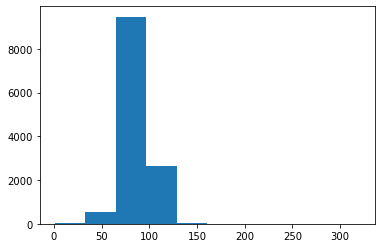

In [32]:
import matplotlib.pyplot as plt

plt.hist(samples)
plt.show()